In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dengue as dg
from scipy.optimize import curve_fit
import datetime

from warnings import filterwarnings
filterwarnings('ignore')

# Load and Plot data

In [2]:
sj_data, iq_data = dg.preprocess_data('Data/dengue_features_train.csv',
                                      "Data/dengue_labels_train.csv")

In [3]:
sj_data.head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,Counts
1990-04-30,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Plot the cases for San Juan and Iquitos

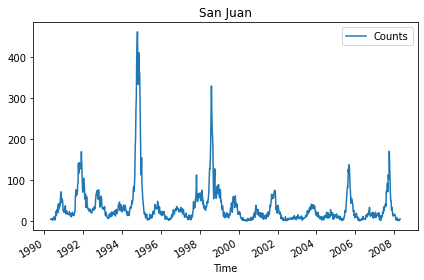

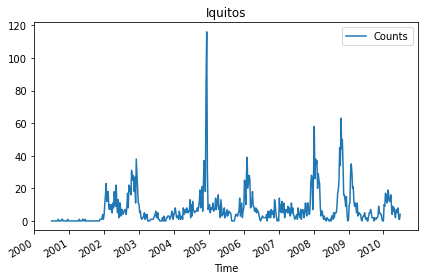

In [4]:
sj_data.plot(y='Counts', title='San Juan')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('figures/sj_cases.pdf',bbox_inches='tight')

iq_data.plot(y='Counts', title='Iquitos')
plt.xlabel('Time')
plt.tight_layout()
plt.savefig('figures/iq_cases.pdf',bbox_inches='tight')

Compare the case counts to average temperature

<AxesSubplot:title={'center':'Avg Temp'}>

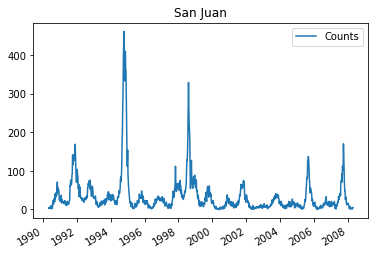

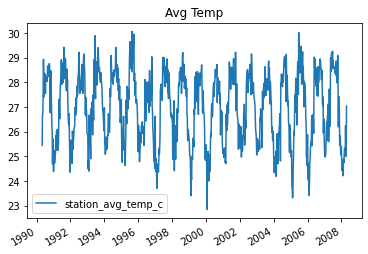

In [5]:
sj_data.plot(y='Counts', title='San Juan')
sj_data.plot(y='station_avg_temp_c', title='Avg Temp')

Compare San Juan to Iquitos

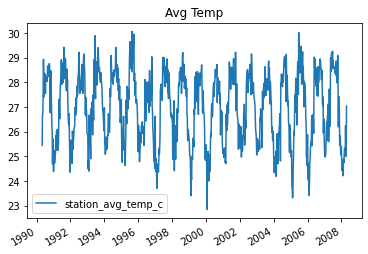

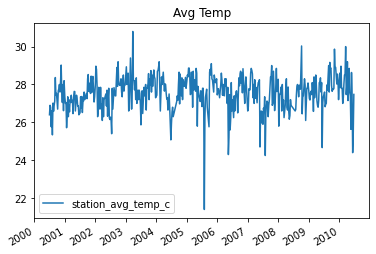

In [6]:
sj_data.plot(y='station_avg_temp_c', title='Avg Temp')
ax = iq_data.plot(y='station_avg_temp_c', title='Avg Temp')
#ax.set_xlim([datetime.date(2002, 1, 26), datetime.date(2004, 2, 1)])
# Iquitos does not exhibit strong seasonality like San Juan!!

In [7]:
sj_mean = sj_data.mean()['Counts']
sj_var  = sj_data.var()['Counts']
print('San Juan')
print('mean: ', sj_mean)
print('var :', sj_var)


iq_mean = iq_data.mean()['Counts']
iq_var  = iq_data.var()['Counts']
print('\nIquitos')
print('mean: ', iq_mean)
print('var :', iq_var)

San Juan
mean:  34.18055555555556
var : 2640.045439691045

Iquitos
mean:  7.565384615384615
var : 115.8955239365642


# Correlations

In [8]:
sj_corr_orig = sj_data.corr()
iq_corr_orig = iq_data.corr()

sj_corr_orig = sj_corr_orig['Counts'].drop(['Counts','weekofyear'])
iq_corr_orig = iq_corr_orig['Counts'].drop(['Counts','weekofyear'])

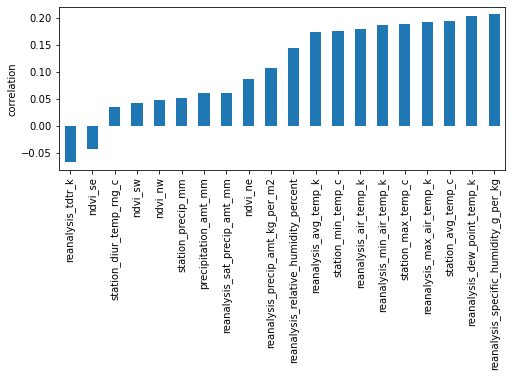

In [9]:
plt.figure(figsize=(8,3))
ax = (sj_corr_orig
      .sort_values(ascending=True)
      .plot
      .bar(figsize=(8,3)))

ax.set_ylabel('correlation')
plt.tight_layout()
plt.savefig('figures/sj_corr.pdf',bbox_inches='tight')

## Correlate to average over preceeding weeks

In [10]:
def improve_corr(data, city):

    # create new data field
    new_data = data.drop('weekofyear',axis=1)

    # initialize empty lists
    cor_name = []
    cor_max_corr = []
    cor_Nweeks = []
    
    if city == 'sj':
        crit_val = 0.3
    elif city == 'iq':
        crit_val = 0.2
    
    for quant in new_data.columns:
        lst = []
        
        # average over increasing number of preceeding weeks
        for ii in range(52):
            data_avg = new_data[quant].rolling(ii).mean()
            new_data['avg_data'] = data_avg
            corr = new_data.corr()
            lst.append(corr['Counts']['avg_data'])

        if len(lst) > 2:
            if max(lst[2:]) > crit_val:
                max_corr = max(lst[2:])
                Nweeks = lst.index(max(lst[2:]))+2
                print(quant, '\t\t%0.3g'%max_corr, 'Nweeks: ', Nweeks )
                cor_name.append(quant)
                cor_max_corr.append(max_corr)
                cor_Nweeks.append(Nweeks)
        
                #plt.figure()
                #plt.plot(lst)
                #plt.title(quant)
                if quant == 'station_avg_temp_c':
                    plt.figure()
                    plt.plot(lst)
                    plt.title(quant)
                    plt.xlabel('weeks')
                    plt.ylabel('correlation')
                    plt.savefig('figures/avg_temp_corr.pdf')

reanalysis_air_temp_k 		0.309 Nweeks:  18
reanalysis_avg_temp_k 		0.307 Nweeks:  18
reanalysis_dew_point_temp_k 		0.335 Nweeks:  19
reanalysis_max_air_temp_k 		0.324 Nweeks:  18
reanalysis_min_air_temp_k 		0.336 Nweeks:  18
reanalysis_specific_humidity_g_per_kg 		0.331 Nweeks:  18
station_avg_temp_c 		0.428 Nweeks:  25
station_max_temp_c 		0.457 Nweeks:  27
station_min_temp_c 		0.425 Nweeks:  23
Counts 		0.991 Nweeks:  4


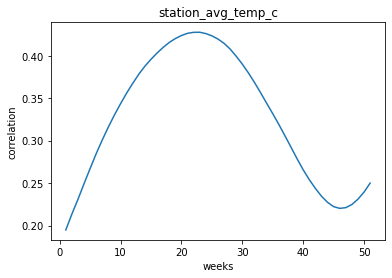

In [11]:
improve_corr(sj_data, 'sj')

In [12]:
#improve_corr(iq_data, 'iq')

# Fit a sinusoid

It's a VERY simple model, but gives a baseline to build off of

## San Juan

In [13]:
# sinusoidal fitting function
def f_func(t, a, b, c, phi):
    return a * np.sin(2*np.pi*b*(t + phi)) + c

In [14]:
# curve fit
sj_time_var = np.arange(len(sj_data))
popt, _ = curve_fit(f_func, sj_time_var, sj_data['Counts'],[30, 1/52, 20, 5])
sj_a,sj_b,sj_c,sj_phi = popt

In [15]:
print('Fitting parameters:')
print(popt)

Fitting parameters:
[ 2.93316956e+01  1.94099128e-02  3.44321004e+01 -1.47891422e+01]


In [16]:
print('period: ',1/sj_b,'weeks')

period:  51.52006664673527 weeks


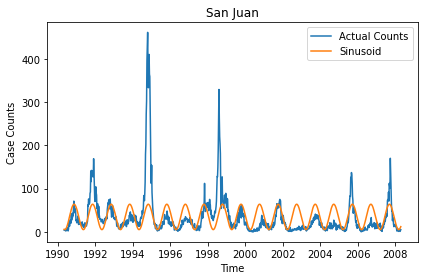

In [17]:
sj_plot, = plt.plot(sj_data.index.values, sj_data['Counts'], label='Actual Counts')
sj_sine, = plt.plot(sj_data.index.values, f_func(sj_time_var, sj_a, sj_b, sj_c, sj_phi), label='Sinusoid')

plt.legend(handles=[sj_plot, sj_sine])
plt.ylabel('Case Counts')
plt.xlabel('Time')
plt.title('San Juan')

plt.tight_layout()
plt.savefig('figures/sj_sine.pdf',bbox_inches='tight')

## Iquitos

In [18]:
iq_time_var = np.arange(len(iq_data))
popt, _ = curve_fit(f_func, iq_time_var, iq_data['Counts'],[30, 1/52, 34, 0])
iq_a,iq_b,iq_c,iq_phi = popt

In [19]:
print('Fitting parameters:')
print(popt)

Fitting parameters:
[  4.96905007   0.01919935   7.55725192 -12.14289693]


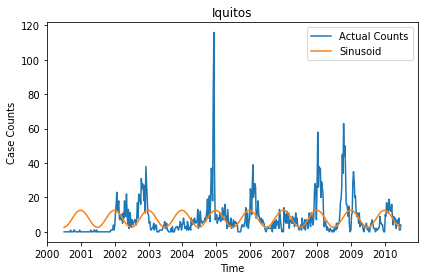

In [20]:
iq_plot, = plt.plot(iq_data.index.values, iq_data['Counts'], label='Actual Counts')
iq_sine, = plt.plot(iq_data.index.values, f_func(iq_time_var, iq_a, iq_b, iq_c, iq_phi), label='Sinusoid')

plt.legend(handles=[iq_plot, iq_sine])
plt.ylabel('Case Counts')
plt.xlabel('Time')
plt.title('Iquitos')

plt.tight_layout()
plt.savefig('figures/iq_sine.pdf',bbox_inches='tight')

In [21]:
# absolute mean squared error

In [22]:
print('San Juan: ',((f_func(sj_time_var, sj_a, sj_b, sj_c, sj_phi) - sj_data['Counts'])**2).mean())
print('Iquitos:  ',((f_func(iq_time_var, iq_a, iq_b, iq_c, iq_phi) - iq_data['Counts'])**2).mean())

San Juan:  2204.1803690273914
Iquitos:   103.34719860674643


# create new data

In [23]:
def create_new_data(data, loc):
    if loc == 'sj':
        nc = 25
        quant_list = [
                  'reanalysis_avg_temp_k',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'station_max_temp_c', 
                  'station_avg_temp_c', 
                  'station_min_temp_c']

    elif loc == 'iq':
        nc = 8
        quant_list = [
            'reanalysis_dew_point_temp_k',
            'reanalysis_min_air_temp_k',
            'reanalysis_specific_humidity_g_per_kg',
            'station_min_temp_c'
                    ]

    quant_list2 = []
    for quant in quant_list:
        for ii in range(nc):
            sum_val = data[quant].rolling(ii).sum()
            #sum_val = data[quant].shift(ii)
            sum_val = sum_val.fillna(method='backfill')
            sum_val.name = sum_val.name+'_sum_'+str(ii)
            data.loc[:, sum_val.name] = sum_val.values
            quant_list2.append(sum_val.name)
    
    return data, quant_list2

In [24]:
sj_data, sj_quant_list = create_new_data(sj_data,'sj')
iq_data, iq_quant_list = create_new_data(iq_data,'iq')

how do these correlate to the number of case counts?

In [25]:
sj_corr = sj_data.corr()
iq_corr = iq_data.corr()

In [26]:
#plt.figure(figsize=(8,3))
#sj_corr['Counts'].plot.barh(figsize=(5,30))

In [27]:
#[print(x) for x in sj_corr['Counts'].index];

# Split into separate sections

In [28]:
sj_split = round(len(sj_data['Counts'])*0.8)
iq_split = round(len(iq_data['Counts'])*0.8)

In [29]:
sj_train = sj_data[:sj_split]
sj_test  = sj_data[sj_split:]
iq_train = iq_data[:iq_split]
iq_test  = iq_data[iq_split:]

# train model

In [30]:
sj_predictions_summary_frame, sj_y_test, sj_X_test, sj_predictions_summary_frame_train = \
        dg.make_model_fit(sj_train, sj_test, sj_quant_list)

alpha:  0.31844613580869685
LAMBDA    0.318446
dtype: float64
t values:
LAMBDA    8.205067
dtype: float64


In [31]:
iq_predictions_summary_frame, iq_y_test, iq_X_test, iq_predictions_summary_frame_train = \
        dg.make_model_fit(iq_train, iq_test, iq_quant_list)

alpha:  1.3592842222871753
LAMBDA    1.359284
dtype: float64
t values:
LAMBDA    5.491005
dtype: float64


# Plot the model on the training data

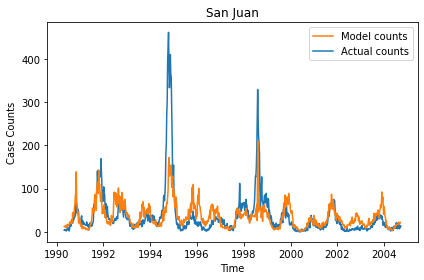

In [32]:
sj_pred = sj_predictions_summary_frame_train[sj_predictions_summary_frame_train.index < sj_train.index[-1]]['mean']

actual, = plt.plot(sj_train['Counts'], label='Actual counts')
predicted, = plt.plot(sj_pred, label='Model counts')

#plt.fill_between(sj_predictions_summary_frame_train.index, \
#                 sj_predictions_summary_frame_train['mean_ci_lower'], \
#                 sj_predictions_summary_frame_train['mean_ci_upper'], alpha=.5)

plt.legend(handles=[predicted, actual])
plt.ylabel('Case Counts')
plt.xlabel('Time')
plt.title('San Juan')

plt.tight_layout()
plt.savefig('figures/sj_model.pdf',bbox_inches='tight')

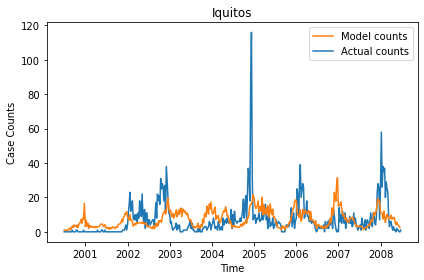

In [33]:
iq_pred = iq_predictions_summary_frame_train[iq_predictions_summary_frame_train.index < iq_train.index[-1]]['mean']

actual, = plt.plot(iq_train['Counts'], label='Actual counts')
predicted, = plt.plot(iq_pred, label='Model counts')
plt.legend(handles=[predicted, actual])
plt.ylabel('Case Counts')
plt.xlabel('Time')
plt.title('Iquitos')

plt.tight_layout()
plt.savefig('figures/iq_model.pdf',bbox_inches='tight')

In [34]:
#sj_error = abs(sj_predicted_counts - sj_actual_counts).mean()
#iq_error = abs(iq_predicted_counts - iq_actual_counts).mean()
sj_error = ((sj_pred - sj_train['Counts'])**2).mean()
iq_error = ((iq_pred - iq_train['Counts'])**2).mean()
print('SJ error: ', sj_error)
print('IQ error: ', iq_error)

SJ error:  1768.992925944971
IQ error:  102.26743538730014


# Plot prediction

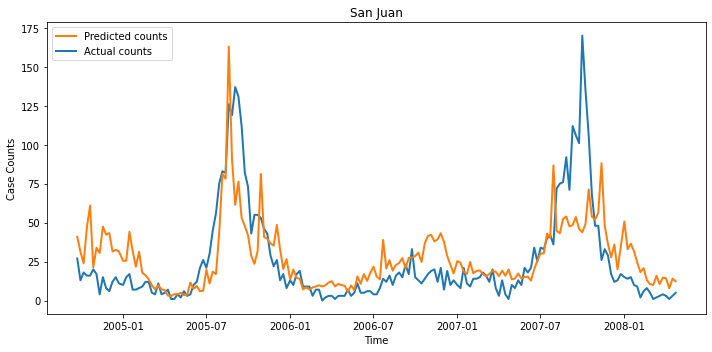

In [35]:
sj_predicted_counts = sj_predictions_summary_frame['mean']
sj_actual_counts    = sj_y_test['Counts']

fig = plt.figure(figsize=(10,5))
plt.ylabel('Case Counts')
plt.xlabel('Time')
plt.title('San Juan')
actual,    = plt.plot(sj_X_test.index, sj_actual_counts,    label='Actual counts',    lw=2)
predicted, = plt.plot(sj_X_test.index, sj_predicted_counts, label='Predicted counts', lw=2)


plt.legend(handles=[predicted, actual])
#plt.xlim([datetime.date(1990, 1, 1), datetime.date(2000, 1, 1)])
#plt.show()

# labels
plt.tight_layout()
plt.savefig('figures/sj_prediction.pdf',bbox_inches='tight')

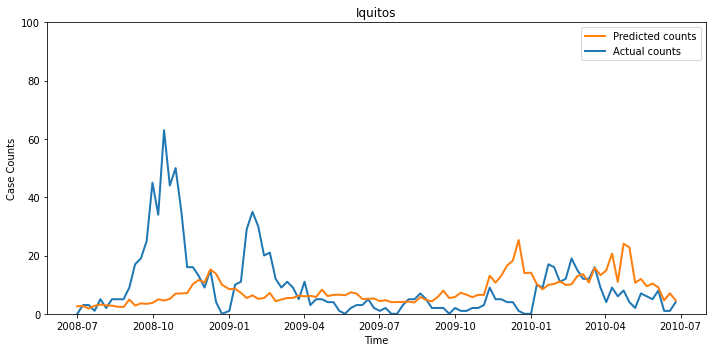

In [36]:
iq_predicted_counts = iq_predictions_summary_frame['mean']
iq_actual_counts = iq_y_test['Counts']

fig = plt.figure(figsize=(10,5))
plt.ylabel('Case Counts')
plt.xlabel('Time')
plt.title('Iquitos')
actual,    = plt.plot(iq_X_test.index, iq_actual_counts,    label='Actual counts', lw=2)
predicted, = plt.plot(iq_X_test.index, iq_predicted_counts, label='Predicted counts', lw=2)


plt.legend(handles=[predicted, actual])
#plt.xlim([datetime.date(1990, 1, 1), datetime.date(2000, 1, 1)])
plt.ylim([0, 100])

# labels
plt.tight_layout()
plt.savefig('figures/iq_prediction.pdf',bbox_inches='tight')

# Calculate Mean Absolute Error

In [37]:
#sj_error = abs(sj_predicted_counts - sj_actual_counts).mean()
#iq_error = abs(iq_predicted_counts - iq_actual_counts).mean()
sj_error = ((sj_predicted_counts - sj_actual_counts)**2).mean()
iq_error = ((iq_predicted_counts - iq_actual_counts)**2).mean()
print('SJ error: ', sj_error)
print('IQ error: ', iq_error)

SJ error:  522.3544576025208
IQ error:  165.0366976086089


# Make Prediction for Competition

In [38]:
sj_comp, iq_comp = dg.preprocess_data('Data/dengue_features_test.csv')

sj_comp2, sj_quant_list = create_new_data(sj_comp, 'sj')
iq_comp2, iq_quant_list = create_new_data(iq_comp, 'iq')

sj_comp2['Counts'] = 0
iq_comp2['Counts'] = 0

sj_predictions_summary_frame, sj_y_test, sj_X_test, sj_predictions_summary_frame_train = dg.make_model_fit(sj_data, sj_comp2, sj_quant_list)
iq_predictions_summary_frame, iq_y_test, iq_X_test, iq_predictions_summary_frame_train = dg.make_model_fit(iq_data, iq_comp2, iq_quant_list)

sj_predictions = sj_predictions_summary_frame['mean']
iq_predictions = iq_predictions_summary_frame['mean']

alpha:  0.34952221566764347
LAMBDA    0.349522
dtype: float64
t values:
LAMBDA    9.017657
dtype: float64
alpha:  1.4280980366594078
LAMBDA    1.428098
dtype: float64
t values:
LAMBDA    5.215136
dtype: float64


In [39]:
sj_predictions.fillna(method='bfill',inplace=True)
iq_predictions.fillna(method='bfill',inplace=True)
sj_predictions = sj_predictions.astype(int)
iq_predictions = iq_predictions.astype(int)

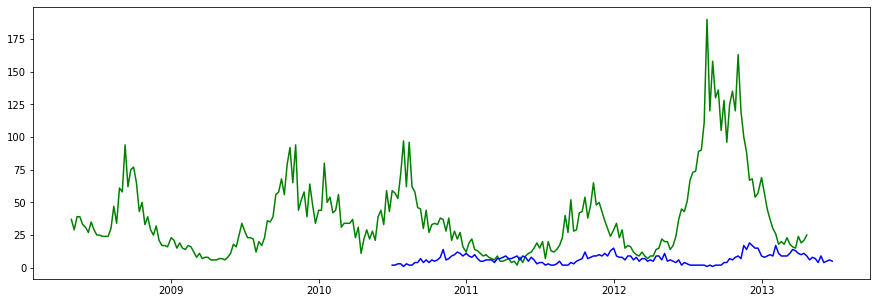

In [40]:
fig = plt.figure(figsize=(15,5))
sj_predicted, = plt.plot(sj_X_test.index, sj_predictions, 'g-', label='Predicted San Juan')
iq_predicted, = plt.plot(iq_X_test.index, iq_predictions, 'b-', label='Predicted Iquitos')

#plt.legend(handles=[predicted, actual])
#plt.xlim([datetime.date(1990, 1, 1), datetime.date(2000, 1, 1)])
plt.show()

In [41]:
submission = pd.read_csv("Data/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("Data/benchmark.csv")